Simple forecasting methods include naively using the last observation as the prediction or an average of prior observations. In this tutorial, you will discover how to develop a framework from scratch for grid searching simple naive and averaging strategies for time series forecasting with univariate data.


- How to develop a framework for grid searching simple models from scratch using walk- forward validation.
- How to grid search simple model hyperparameters for daily time series data for births.
- How to grid search simple model hyperparameters for monthly time series data for shampoo sales, car sales, and temperature.

## 11.1 Tutorial Overview
1. Simple Forecasting Strategies
2. Develop a Grid Search Framework
3. Case Study 1: No Trend or Seasonality
4. Case Study 2: Trend
5. Case Study 3: Seasonality
6. Case Study 4: Trend and Seasonality

## 11.2 Simple Forecasting Strategies
There are two main themes to simple forecast strategies; they are:
- Naive, or using observations values directly.
- Average, or using a statistic calculated on previous observations.

## 11.3 Develop a Grid Search Framework


We can start off by implementing a naive forecast strategy. For a given dataset of historical observations, we can persist any value in that history, that is from the previous observation at index -1 to the first observation in the history at -(len(data)). 

In [1]:
# example of a one-step naive forecast
def naive_forecast(history, n):
	return history[-n]

# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
	print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


We can now look at developing a function for the average forecast strategy. Averaging the last n observations is straight-forward; 


The average forecast() function below implements this taking the historical data and a config array or tuple that specifies the number of prior values to average as an integer, and a string that describe the way to calculate the average (mean or median).

In [2]:
# example of an average forecast
from numpy import mean
from numpy import median

# one-step average forecast
def average_forecast(history, config):
	n, avg_type = config
	# mean of last n values
	if avg_type is 'mean':
		return mean(history[-n:])
	# median of last n values
	return median(history[-n:])

# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
	print(average_forecast(data, (i, 'mean')))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
95.0
90.0
85.0
80.0
75.0
70.0
65.0
60.0
55.0


We can update the function to support averaging over seasonal data, respecting the seasonal offset. An offset argument can be added to the function that when not set to 1 will determine the number of prior observations backwards to count before collecting values from which to include in the average. For example, if n=1 and offset=3, then the average is calculated from the single value at n×offset or 1×3 = −3. If n = 2 and offset = 3, then the average is calculated from the values at 1 × 3 or -3 and 2 × 3 or -6. 

In [5]:
# example of an average forecast for seasonal data 
from numpy import mean 
from numpy import median 

# one-step average forecast 
def average_forecast(history, config):
    n, offset, avg_type = config 
    values = []
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs 
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n, offset))
        # try and collect n values using offset 
        for i in range(1, n + 1):
            idx = i * offset
            values.append(history[-idx])
    # mean of last n values 
    if avg_type is 'mean':
        return mean(values)
    # median of last n values 
    return median(values)

# define dataset
data = [10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
print(data)
# test naive forecast
for i in [1, 2, 3]:
    print(average_forecast(data, (i, 3, 'mean')))

[10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
10.0
10.0
10.0


- The train test split() function below implements this for a provided dataset and a specified number of time steps to use in the test set.

- The measure rmse() function below will calculate the RMSE given a list of actual (the test set) and predicted values.

- The walk forward validation() function below implements this, taking a univariate time series, a number of time steps to use in the test set, and an array of model configuration.

- We can trap exceptions and ignore warnings during the grid search by wrapping all calls to walk forward validation() with a try-except and a block to ignore warnings. We can also add debugging support to disable these protections in the case we want to see what is really going on. Finally, if an error does occur, we can return a None result; otherwise, we can print some information about the skill of each model evaluated. This is helpful when a large number of models are evaluated. The score model() function below implements this and returns a tuple of (key and result), where the key is a string version of the tested model configuration.

- We can then sort all tuples in the list by the score in ascending order (best are first), then return this list of scores for review. The __grid search()__ function below implements this behavior given a univariate time series dataset, a list of model configurations (list of lists), and the number of time steps to use in the test set. An optional parallel argument allows the evaluation of models across all cores to be tuned on or off, and is on by default.
- The only thing left to do is to define a list of model configurations to try for a dataset. We can define this generically. The only parameter we may want to specify is the periodicity of the seasonal component in the series (offset), if one exists. By default, we will assume no seasonal component. The __simple_configs()__ function below will create a list of model configurations to evaluate.

In [12]:
# grid search simple forecasts 
from math import sqrt 
from numpy import mean 
from numpy import median 
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings 
from sklearn.metrics import mean_squared_error

# one-step simple forecast 
def simple_forecast(history, config):
    n, offset, avg_type = config 
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n]
    
    # collect values to average 
    values = []
    if offset == 1:
        values = history[-n:]
    else:
        # skip bad configs
        if n * offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n, offset))
        # try and collect n values using offset 
        for i in range(1, n+1):
            idx = i * offset
            values.append(history[-idx])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values 
    if avg_type == 'mean':
        return mean(values)
    # median of last n values 
    return median(values)

# root mean squared error or rmse 
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = []
    # split dataset 
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set 
    for i in range(len(test)):
        # fit model and make forecast for history 
        yhat = simple_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop 
        history.append(test[i])
    # estimate prediction error 
    error = measure_rmse(test, predictions)
    return error 

# score a model, return None on failure, return 
def score_model(data, n_test, cfg, debug=False):
    result = None 
    # convert config to a key 
    key = str(cfg)
    # show all warnings and fail on exception if debugging 
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None 
    # check for an interesting result 
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs, return a list of score 
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None 
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores 

# create a set of simple configs to try, return a list 
def simple_configs(max_length, offsets=[1]):
    configs = []
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs 

if __name__ == '__main__':
    # define dataset 
    data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
    # data split 
    n_test = 4 
    # model configs 
    max_length = len(data) - n_test 
    cfg_list = simple_configs(max_length)
    # grid search 
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

 > Model[[1, 1, 'persist']] 10.000
 > Model[[2, 1, 'persist']] 20.000
 > Model[[2, 1, 'mean']] 15.000
 > Model[[2, 1, 'median']] 15.000
 > Model[[3, 1, 'mean']] 20.000
 > Model[[3, 1, 'persist']] 30.000
 > Model[[3, 1, 'median']] 20.000
 > Model[[4, 1, 'persist']] 40.000
 > Model[[4, 1, 'mean']] 25.000
 > Model[[4, 1, 'median']] 25.000
 > Model[[5, 1, 'persist']] 50.000
 > Model[[5, 1, 'mean']] 30.000
 > Model[[5, 1, 'median']] 30.000
 > Model[[6, 1, 'persist']] 60.000
 > Model[[6, 1, 'mean']] 35.000
 > Model[[6, 1, 'median']] 35.000
done
[1, 1, 'persist'] 10.0
[2, 1, 'mean'] 15.0
[2, 1, 'median'] 15.0


- What does the delayed() function do (when used with joblib in Python) https://stackoverflow.com/questions/42220458/what-does-the-delayed-function-do-when-used-with-joblib-in-python
- class joblib.Parallel https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
- Parallel Processing in Python https://homes.cs.washington.edu/~jmschr/lectures/Parallel_Processing_in_Python.html

## 11.4 Case Study 1: No Trend or Seasonality

- The daily female births dataset summarizes the daily total female births in California, USA in 1959. You can download the dataset directly from here (https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)
- The dataset has one year, or 365 observations. We will use the first 200 for training and the remaining 165 as the test set.

We can now grid search naive models for the dataset. The complete example grid searching the daily female univariate time series forecasting problem is listed below

(365, 1)


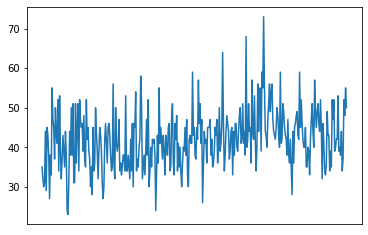

In [14]:
# load and plot daily births dataset
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline

# load
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [15]:
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 165
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 8.722
 > Model[[2, 1, 'persist']] 9.284
 > Model[[2, 1, 'mean']] 7.884
 > Model[[2, 1, 'median']] 7.884
 > Model[[3, 1, 'persist']] 9.320
 > Model[[3, 1, 'mean']] 7.518
 > Model[[17, 1, 'persist']] 9.813
 > Model[[30, 1, 'mean']] 7.023
 > Model[[3, 1, 'median']] 7.324
 > Model[[4, 1, 'persist']] 9.249
 > Model[[17, 1, 'mean']] 7.118
 > Model[[4, 1, 'mean']] 7.290
 > Model[[43, 1, 'median']] 7.130
 > Model[[44, 1, 'persist']] 9.726
 > Model[[17, 1, 'median']] 7.290
 > Model[[18, 1, 'persist']] 9.611
 > Model[[44, 1, 'mean']] 7.078
 > Model[[30, 1, 'median']] 7.140
 > Model[[31, 1, 'persist']] 10.180
 > Model[[4, 1, 'median']] 7.217
 > Model[[31, 1, 'mean']] 7.038
 > Model[[5, 1, 'persist']] 9.415
 > Model[[18, 1, 'mean']] 7.093
 > Model[[5, 1, 'mean']] 7.204
 > Model[[18, 1, 'median']] 7.247
 > Model[[31, 1, 'median']] 7.106
 > Model[[19, 1, 'persist']] 9.656
 > Model[[44, 1, 'median']] 7.101
 > Model[[45, 1, 'persist']] 9.666
 > Model[[45, 1, 'mean']] 7.069


 > Model[[88, 1, 'median']] 7.177
 > Model[[89, 1, 'persist']] 9.652
 > Model[[100, 1, 'median']] 7.247
 > Model[[101, 1, 'persist']] 10.724
 > Model[[77, 1, 'median']] 7.148
 > Model[[78, 1, 'persist']] 10.221
 > Model[[66, 1, 'median']] 7.074
 > Model[[89, 1, 'mean']] 7.234
 > Model[[67, 1, 'persist']] 10.082
 > Model[[78, 1, 'mean']] 7.203
 > Model[[101, 1, 'mean']] 7.291
 > Model[[67, 1, 'mean']] 7.136
 > Model[[101, 1, 'median']] 7.263
 > Model[[89, 1, 'median']] 7.185
 > Model[[102, 1, 'persist']] 10.198
 > Model[[90, 1, 'persist']] 10.493
 > Model[[78, 1, 'median']] 7.132
 > Model[[79, 1, 'persist']] 10.741
 > Model[[67, 1, 'median']] 7.084
 > Model[[68, 1, 'persist']] 10.359
 > Model[[102, 1, 'mean']] 7.292
 > Model[[90, 1, 'mean']] 7.236
 > Model[[68, 1, 'mean']] 7.143
 > Model[[79, 1, 'mean']] 7.213
 > Model[[68, 1, 'median']] 7.108
 > Model[[69, 1, 'persist']] 10.415
 > Model[[90, 1, 'median']] 7.198
 > Model[[91, 1, 'persist']] 10.736
 > Model[[102, 1, 'median']] 7.274
 > M

 > Model[[165, 1, 'median']] 7.577
 > Model[[166, 1, 'persist']] 10.527
 > Model[[160, 1, 'persist']] 10.574
 > Model[[167, 1, 'median']] 7.609
 > Model[[168, 1, 'persist']] 10.855
 > Model[[155, 1, 'median']] 7.492
 > Model[[156, 1, 'persist']] 10.690
 > Model[[160, 1, 'mean']] 7.460
 > Model[[168, 1, 'mean']] 7.476
 > Model[[166, 1, 'mean']] 7.474
 > Model[[156, 1, 'mean']] 7.435
 > Model[[160, 1, 'median']] 7.548
 > Model[[168, 1, 'median']] 7.602
 > Model[[161, 1, 'persist']] 10.855
 > Model[[169, 1, 'persist']] 11.029
 > Model[[166, 1, 'median']] 7.591
 > Model[[169, 1, 'mean']] 7.481
 > Model[[156, 1, 'median']] 7.506
 > Model[[161, 1, 'mean']] 7.465
 > Model[[170, 1, 'mean']] 7.483
 > Model[[173, 1, 'median']] 7.607
 > Model[[174, 1, 'persist']] 10.701
 > Model[[161, 1, 'median']] 7.563
 > Model[[162, 1, 'persist']] 10.597
 > Model[[169, 1, 'median']] 7.606
 > Model[[170, 1, 'persist']] 10.879
 > Model[[177, 1, 'persist']] 11.211
 > Model[[162, 1, 'mean']] 7.467
 > Model[[174, 1

We can see that the best result was an RMSE of about 6.93 births with the following configuration:
- Strategy: Average 􏰀 
- n: 22
- function: mean()

This is surprising given the lack of trend or seasonality, I would have expected either a persistence of -1 or an average of the entire historical dataset to result in the best performance.

## 11.5 Case Study 2: Trend

- The monthly shampoo sales dataset summarizes the monthly sales of shampoo over a three-year period. You can download the dataset directly from here: https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

- The dataset has three years, or 36 observations. We will use the first 24 for training and the remaining 12 as the test set.

(36, 1)


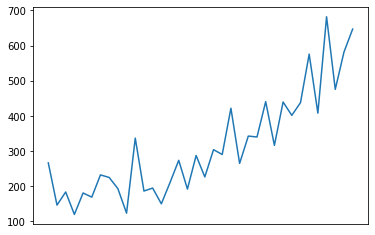

In [16]:
# load and plot monthly shampoo sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

A line plot of the series is also created. We can see that there is an obvious trend and no obvious seasonality.

In [17]:
# grid search simple forecast for monthly shampoo sales
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# load dataset
	series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 12
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 136.761
 > Model[[2, 1, 'mean']] 96.011
 > Model[[2, 1, 'persist']] 95.695
 > Model[[2, 1, 'median']] 96.011
 > Model[[3, 1, 'persist']] 123.969
 > Model[[3, 1, 'mean']] 96.403
 > Model[[3, 1, 'median']] 103.634
 > Model[[4, 1, 'persist']] 136.813
 > Model[[4, 1, 'mean']] 100.609
 > Model[[4, 1, 'median']] 104.878
 > Model[[5, 1, 'persist']] 127.656
 > Model[[5, 1, 'mean']] 101.862
 > Model[[5, 1, 'median']] 101.819
 > Model[[6, 1, 'persist']] 165.500
 > Model[[6, 1, 'mean']] 110.425
 > Model[[6, 1, 'median']] 114.959
 > Model[[7, 1, 'persist']] 164.514
 > Model[[7, 1, 'mean']] 115.500
 > Model[[7, 1, 'median']] 124.605
 > Model[[8, 1, 'persist']] 186.545
 > Model[[8, 1, 'mean']] 122.807
 > Model[[8, 1, 'median']] 132.409
 > Model[[9, 1, 'persist']] 193.951
 > Model[[9, 1, 'mean']] 128.902
 > Model[[9, 1, 'median']] 136.633
 > Model[[10, 1, 'persist']] 205.511
 > Model[[10, 1, 'mean']] 135.664
 > Model[[10, 1, 'median']] 142.336
 > Model[[11, 1, 'persist']] 

We can see that the best result was an RMSE of about 95.69 sales with the following configuration:
- Strategy: Persist 􏰀 
- n: 2

This is surprising as the trend structure of the data would suggest that persisting the previous value (-1) would be the best approach, not persisting the second last value.

## 11.6 Case Study 3: Seasonality

- The monthly mean temperatures dataset summarizes the monthly average air temperatures in Nottingham Castle, England from 1920 to 1939 in degrees Fahrenheit. You can download the dataset directly from here: https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-mean-temp.csv
- Running the example first summarizes the shape of the loaded dataset. The dataset has 20 years, or 240 observations.

(240, 1)


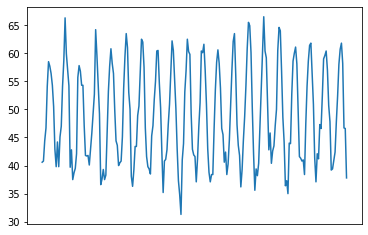

In [18]:
# load and plot monthly mean temp dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

- We will trim the dataset to the last five years of data (60 observations) in order to speed up the model evaluation process and use the last year or 12 observations for the test set.
- The period of the seasonal component is about one year, or 12 observations. We will use this as the seasonal period in the call to the simple configs() function when preparing the model configurations.

In [19]:
# grid search simple forecast for monthly mean temperature
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 12
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length, offsets=[1,12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 5.143
 > Model[[2, 1, 'persist']] 8.492
 > Model[[1, 12, 'persist']] 5.143
 > Model[[2, 1, 'mean']] 6.538
 > Model[[2, 1, 'median']] 6.538
 > Model[[10, 1, 'median']] 9.651
 > Model[[18, 1, 'median']] 9.079
 > Model[[26, 1, 'median']] 7.272
 > Model[[10, 12, 'persist']] 7.857
 > Model[[2, 12, 'persist']] 8.492
 > Model[[2, 12, 'mean']] 1.589
 > Model[[10, 12, 'mean']] 1.724
 > Model[[2, 12, 'median']] 1.589
 > Model[[3, 1, 'persist']] 12.006
 > Model[[3, 1, 'mean']] 8.155
 > Model[[3, 1, 'median']] 8.331
 > Model[[10, 12, 'median']] 1.846
 > Model[[11, 1, 'persist']] 4.717
 > Model[[26, 12, 'persist']] 8.756
 > Model[[11, 1, 'mean']] 8.977
 > Model[[18, 12, 'persist']] 15.952
 > Model[[11, 1, 'median']] 9.126
 > Model[[11, 12, 'persist']] 4.717
 > Model[[11, 12, 'mean']] 1.674
 > Model[[27, 1, 'persist']] 11.883
 > Model[[11, 12, 'median']] 1.849
 > Model[[3, 12, 'persist']] 12.006
 > Model[[27, 1, 'mean']] 7.883
 > Model[[18, 12, 'mean']] 1.881
 > Model[[3,

 > Model[[59, 1, 'persist']] 4.617
 > Model[[59, 1, 'mean']] 8.376
 > Model[[46, 12, 'persist']] 9.332
 > Model[[59, 1, 'median']] 8.570
 > Model[[59, 12, 'persist']] 4.617
 > Model[[47, 1, 'persist']] 5.713
 > Model[[60, 1, 'persist']] 3.547
 > Model[[47, 1, 'mean']] 8.443
 > Model[[60, 1, 'mean']] 8.234
 > Model[[47, 1, 'median']] 8.570
 > Model[[60, 1, 'median']] 8.282
 > Model[[60, 12, 'persist']] 3.547
 > Model[[47, 12, 'persist']] 5.713
 > Model[[48, 1, 'persist']] 2.060
 > Model[[61, 1, 'persist']] 5.561
 > Model[[48, 1, 'mean']] 8.255
 > Model[[61, 1, 'mean']] 8.099
 > Model[[48, 1, 'median']] 8.282
 > Model[[61, 1, 'median']] 8.035
 > Model[[48, 12, 'persist']] 2.060
 > Model[[61, 12, 'persist']] 5.561
 > Model[[62, 1, 'persist']] 9.384
 > Model[[62, 1, 'mean']] 8.026
 > Model[[49, 1, 'persist']] 5.325
 > Model[[62, 1, 'median']] 7.871
 > Model[[49, 1, 'mean']] 8.120
 > Model[[62, 12, 'persist']] 9.384
 > Model[[49, 1, 'median']] 8.035
 > Model[[63, 1, 'persist']] 13.069
 > Mo

 > Model[[105, 1, 'median']] 8.687
 > Model[[116, 12, 'persist']] 13.930
 > Model[[117, 1, 'persist']] 11.343
 > Model[[110, 1, 'persist']] 9.012
 > Model[[117, 1, 'mean']] 8.401
 > Model[[117, 1, 'median']] 8.687
 > Model[[105, 12, 'persist']] 11.933
 > Model[[117, 12, 'persist']] 11.343
 > Model[[110, 1, 'mean']] 8.143
 > Model[[106, 1, 'persist']] 8.487
 > Model[[118, 1, 'persist']] 7.950
 > Model[[106, 1, 'mean']] 8.386
 > Model[[118, 1, 'mean']] 8.359
 > Model[[110, 1, 'median']] 8.152
 > Model[[122, 12, 'persist']] 10.304
 > Model[[118, 1, 'median']] 8.582
 > Model[[110, 12, 'persist']] 9.012
 > Model[[130, 1, 'median']] 8.582
 > Model[[123, 1, 'persist']] 13.938
 > Model[[118, 12, 'persist']] 7.950
 > Model[[130, 12, 'persist']] 8.965
 > Model[[111, 1, 'persist']] 12.027
 > Model[[123, 1, 'mean']] 8.125
 > Model[[111, 1, 'mean']] 8.150
 > Model[[131, 1, 'persist']] 4.898
 > Model[[123, 1, 'median']] 8.145
 > Model[[123, 12, 'persist']] 13.938
 > Model[[111, 1, 'median']] 8.145
 

 > Model[[169, 1, 'persist']] 4.141
 > Model[[169, 1, 'mean']] 8.208
 > Model[[171, 1, 'median']] 8.145
 > Model[[161, 1, 'persist']] 15.360
 > Model[[161, 1, 'mean']] 8.233
 > Model[[161, 1, 'median']] 8.342
 > Model[[161, 12, 'persist']] 15.360
 > Model[[171, 12, 'persist']] 11.725
 > Model[[162, 1, 'persist']] 16.276
 > Model[[162, 1, 'mean']] 8.280
 > Model[[186, 1, 'median']] 8.516
 > Model[[172, 1, 'persist']] 14.518
 > Model[[186, 12, 'persist']] 17.469
 > Model[[187, 1, 'persist']] 16.595
 > Model[[187, 1, 'mean']] 8.323
 > Model[[172, 1, 'mean']] 8.216
 > Model[[187, 1, 'median']] 8.676
 > Model[[172, 1, 'median']] 8.245
 > Model[[187, 12, 'persist']] 16.595
 > Model[[172, 12, 'persist']] 14.518
 > Model[[188, 1, 'persist']] 14.910
 > Model[[188, 1, 'mean']] 8.344
 > Model[[173, 1, 'persist']] 15.697
 > Model[[188, 1, 'median']] 8.689
 > Model[[188, 12, 'persist']] 14.910
 > Model[[179, 1, 'mean']] 8.279
 > Model[[169, 1, 'median']] 8.276
 > Model[[173, 1, 'mean']] 8.256
 > Mo

 > Model[[224, 12, 'persist']] 12.991
 > Model[[225, 1, 'persist']] 11.255
 > Model[[218, 1, 'mean']] 8.208
 > Model[[225, 1, 'mean']] 8.322
 > Model[[225, 1, 'median']] 8.627
 > Model[[225, 12, 'persist']] 11.255
 > Model[[226, 1, 'persist']] 8.169
 > Model[[226, 1, 'mean']] 8.309
done
[4, 12, 'mean'] 1.5015616870445234
[8, 12, 'mean'] 1.5794579766489512
[13, 12, 'mean'] 1.586186052546763


We can see that the best result was an RMSE of about 1.50 degrees with the following configuration:
- Strategy: Average 􏰀 
- n: 4
- offset: 12
- function: mean()

This finding is not too surprising. Given the seasonal structure of the data, we would expect a function of the last few observations at prior points in the yearly cycle to be effective.

## 11.7 Case Study 4: Trend and Seasonality


- The monthly car sales dataset summarizes the monthly car sales in Quebec, Canada between 1960 and 1968. You can download the dataset directly from here: https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv
- Running the example first summarizes the shape of the loaded dataset. The dataset has 9 years, or 108 observations. We will use the last year or 12 observations as the test set.

(108, 1)


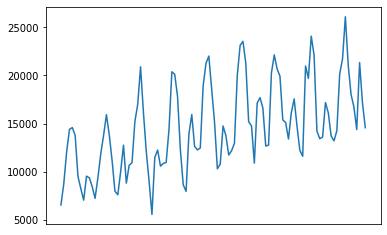

In [20]:
# load and plot monthly car sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

The period of the seasonal component could be six months or 12 months. We will try both as the seasonal period in the call to the simple configs() function when preparing the model configurations.

In [21]:
# grid search simple forecast for monthly car sales
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 12
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length, offsets=[1,12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 3783.966
 > Model[[2, 1, 'persist']] 5171.658
 > Model[[1, 12, 'persist']] 3783.966
 > Model[[2, 1, 'mean']] 4119.852
 > Model[[2, 1, 'median']] 4119.852
 > Model[[11, 1, 'persist']] 4046.661
 > Model[[20, 1, 'persist']] 6353.100
 > Model[[28, 1, 'median']] 4437.448
 > Model[[11, 1, 'mean']] 4295.540
 > Model[[2, 12, 'persist']] 5171.658
 > Model[[20, 1, 'mean']] 4162.190
 > Model[[2, 12, 'mean']] 2215.186
 > Model[[2, 12, 'median']] 2215.186
 > Model[[28, 12, 'persist']] 5587.248
 > Model[[20, 1, 'median']] 4604.653
 > Model[[3, 1, 'persist']] 6000.907
 > Model[[11, 1, 'median']] 5285.049
 > Model[[20, 12, 'persist']] 6353.100
 > Model[[29, 1, 'persist']] 5071.218
 > Model[[3, 1, 'mean']] 4474.174
 > Model[[21, 1, 'persist']] 6458.104
 > Model[[29, 1, 'mean']] 4001.126
 > Model[[3, 1, 'median']] 4243.965
 > Model[[3, 12, 'persist']] 6000.907
 > Model[[21, 1, 'mean']] 4222.612
 > Model[[11, 12, 'persist']] 4046.661
 > Model[[29, 1, 'median']] 4317.304
 > Mod

 > Model[[64, 1, 'mean']] 4329.495
 > Model[[50, 12, 'persist']] 5712.208
 > Model[[64, 1, 'median']] 4865.846
 > Model[[64, 12, 'persist']] 7736.254
 > Model[[51, 1, 'persist']] 6424.278
 > Model[[65, 1, 'persist']] 7645.583
 > Model[[51, 1, 'mean']] 4095.257
 > Model[[51, 1, 'median']] 4632.640
 > Model[[65, 1, 'mean']] 4354.019
 > Model[[51, 12, 'persist']] 6424.278
 > Model[[65, 1, 'median']] 4892.275
 > Model[[52, 1, 'persist']] 6475.089
 > Model[[65, 12, 'persist']] 7645.583
 > Model[[52, 1, 'mean']] 4110.615
 > Model[[66, 1, 'persist']] 7919.315
 > Model[[52, 1, 'median']] 4655.421
 > Model[[66, 1, 'mean']] 4385.550
 > Model[[52, 12, 'persist']] 6475.089
 > Model[[42, 1, 'mean']] 4022.466
 > Model[[53, 1, 'persist']] 6307.894
 > Model[[66, 1, 'median']] 4895.474
 > Model[[66, 12, 'persist']] 7919.315
 > Model[[53, 1, 'mean']] 4117.670
 > Model[[67, 1, 'persist']] 8568.374
 > Model[[42, 1, 'median']] 4456.299
 > Model[[42, 12, 'persist']] 6849.344
 > Model[[53, 1, 'median']] 4666

We can see that the best result was an RMSE of about 1841.15 sales with the following configuration:
- Strategy: Average 􏰀 
- n: 3
- offset: 12
- function: median()

It is not surprising that the chosen model is a function of the last few observations at the same point in prior cycles, although the use of the median instead of the mean may not have been immediately obvious and the results were much better than the mean.


## 11.9 Further Reading

- Forecasting, Wikipedia. https://en.wikipedia.org/wiki/Forecasting

## 11.10 Summary
In this tutorial, you discovered how to develop a framework from scratch for grid searching simple naive and averaging strategies for time series forecasting with univariate data. Specifically, you learned:
- How to develop a framework for grid searching simple models from scratch using walk- forward validation.
- How to grid search simple model hyperparameters for daily time series data for births. 􏰀 
- How to grid search simple model hyperparameters for monthly time series data for shampoo sales, car sales, and temperature.